In [18]:
#1.1
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

def proc_img(filepath):
    
#1.2
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

#1.3
    df = pd.concat([filepath, labels], axis=1)

#1.4    
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

#1.5
train_dir = Path('C:/Users/micue/Documents/Untitled Folder/simpsons_dataset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

#1.6
df = proc_img(filepaths)

print(f'Numero de imagenes: {df.shape[0]}\n')
print(f'Numero de personajes: {len(df.Label.unique())}\n')
print(f'Personajes: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(6)

Numero de imagenes: 8310

Numero de personajes: 6

Personajes: ['moe_szyslak' 'bart_simpson' 'charles_montgomery_burns' 'homer_simpson'
 'ned_flanders' 'apu_nahasapeemapetilon']


,Filepath,Label
0,C:\Users\micue\Documents\Untitled Folder\simps...,moe_szyslak
1,C:\Users\micue\Documents\Untitled Folder\simps...,bart_simpson
2,C:\Users\micue\Documents\Untitled Folder\simps...,charles_montgomery_burns
3,C:\Users\micue\Documents\Untitled Folder\simps...,moe_szyslak
4,C:\Users\micue\Documents\Untitled Folder\simps...,moe_szyslak
5,C:\Users\micue\Documents\Untitled Folder\simps...,bart_simpson


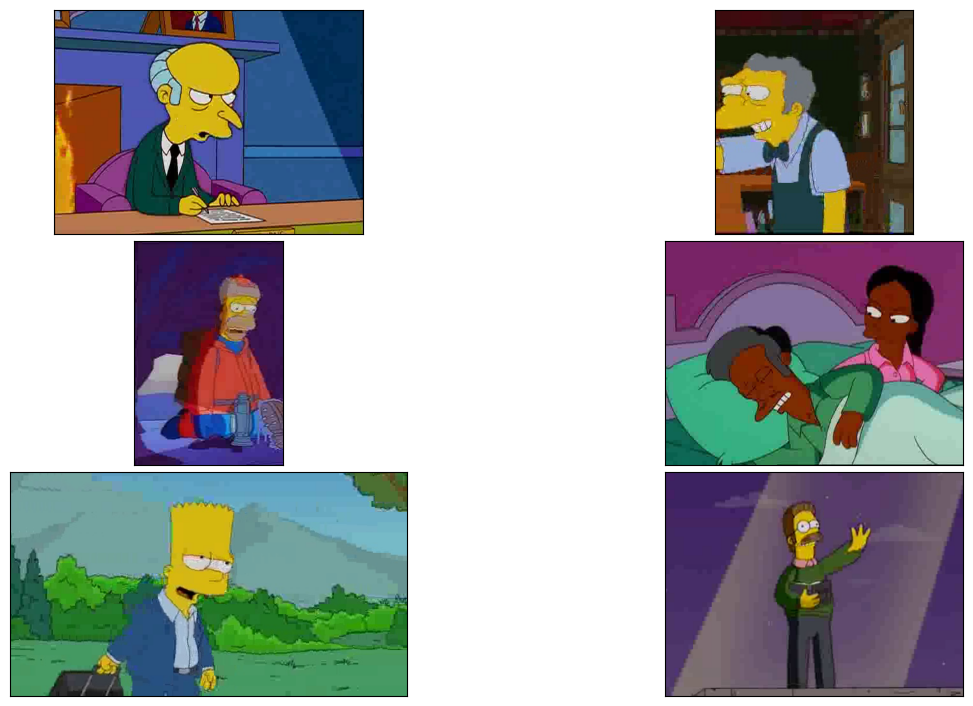

In [6]:
#1.7
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))

plt.tight_layout(pad=0.5)
plt.show()

In [9]:
#2.1
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5319 validated image filenames belonging to 6 classes.
Found 1329 validated image filenames belonging to 6 classes.
Found 1662 validated image filenames belonging to 6 classes.


In [ ]:
#2.2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [43]:
#3.0
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
167/167 [==============================] - 76s 444ms/step - loss: 0.9558 - accuracy: 0.6595 - val_loss: 0.6469 - val_accuracy: 0.7758
Epoch 2/20
167/167 [==============================] - 74s 442ms/step - loss: 0.5171 - accuracy: 0.8223 - val_loss: 0.5385 - val_accuracy: 0.8172
Epoch 3/20
167/167 [==============================] - 74s 443ms/step - loss: 0.4018 - accuracy: 0.8673 - val_loss: 0.5148 - val_accuracy: 0.8330
Epoch 4/20
167/167 [==============================] - 73s 438ms/step - loss: 0.3106 - accuracy: 0.8947 - val_loss: 0.5103 - val_accuracy: 0.8254
Epoch 5/20
167/167 [==============================] - 76s 457ms/step - loss: 0.2371 - accuracy: 0.9235 - val_loss: 0.5326 - val_accuracy: 0.8375
Epoch 6/20
167/167 [==============================] - 75s 449ms/step - loss: 0.1969 - accuracy: 0.9340 - val_loss: 0.5396 - val_accuracy: 0.8352
Epoch 7/20
167/167 [==============================] - 72s 430ms/step - loss: 0.1142 - accuracy: 0.9654 - val_loss: 0.6258 - val_ac

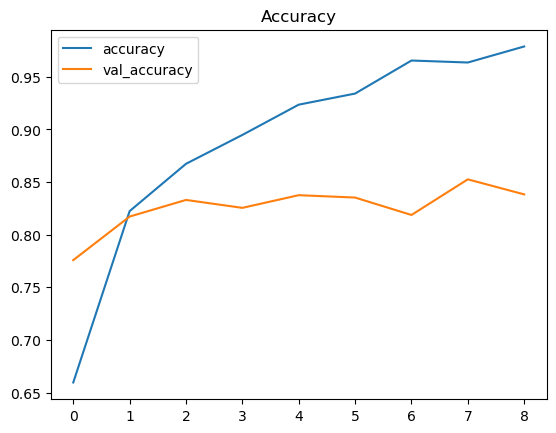

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

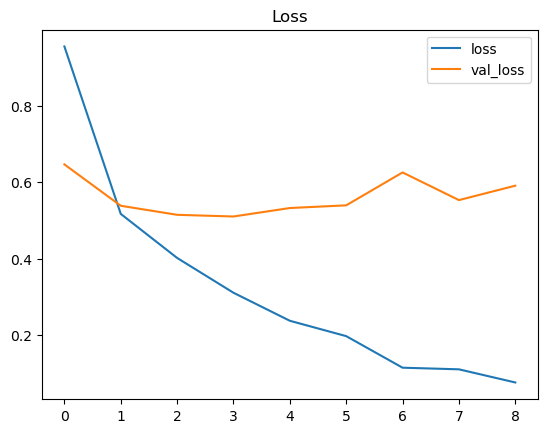

In [45]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [46]:
#4.1
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

#4.2
print(f'The first 5 predictions: {pred[:5]}')

52/52 [==============================] - 19s 359ms/step
The first 5 predictions: ['homer_simpson', 'moe_szyslak', 'homer_simpson', 'charles_montgomery_burns', 'ned_flanders']


In [47]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Presicion de reconocimeinto: {acc * 100:.2f}%')

Presicion de reconocimeinto: 82.85%


In [48]:

from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  apu_nahasapeemapetilon       0.92      0.82      0.86       125
            bart_simpson       0.89      0.87      0.88       257
charles_montgomery_burns       0.91      0.73      0.81       245
           homer_simpson       0.85      0.79      0.82       431
             moe_szyslak       0.78      0.87      0.82       301
            ned_flanders       0.74      0.89      0.81       303

                accuracy                           0.83      1662
               macro avg       0.85      0.83      0.83      1662
            weighted avg       0.84      0.83      0.83      1662



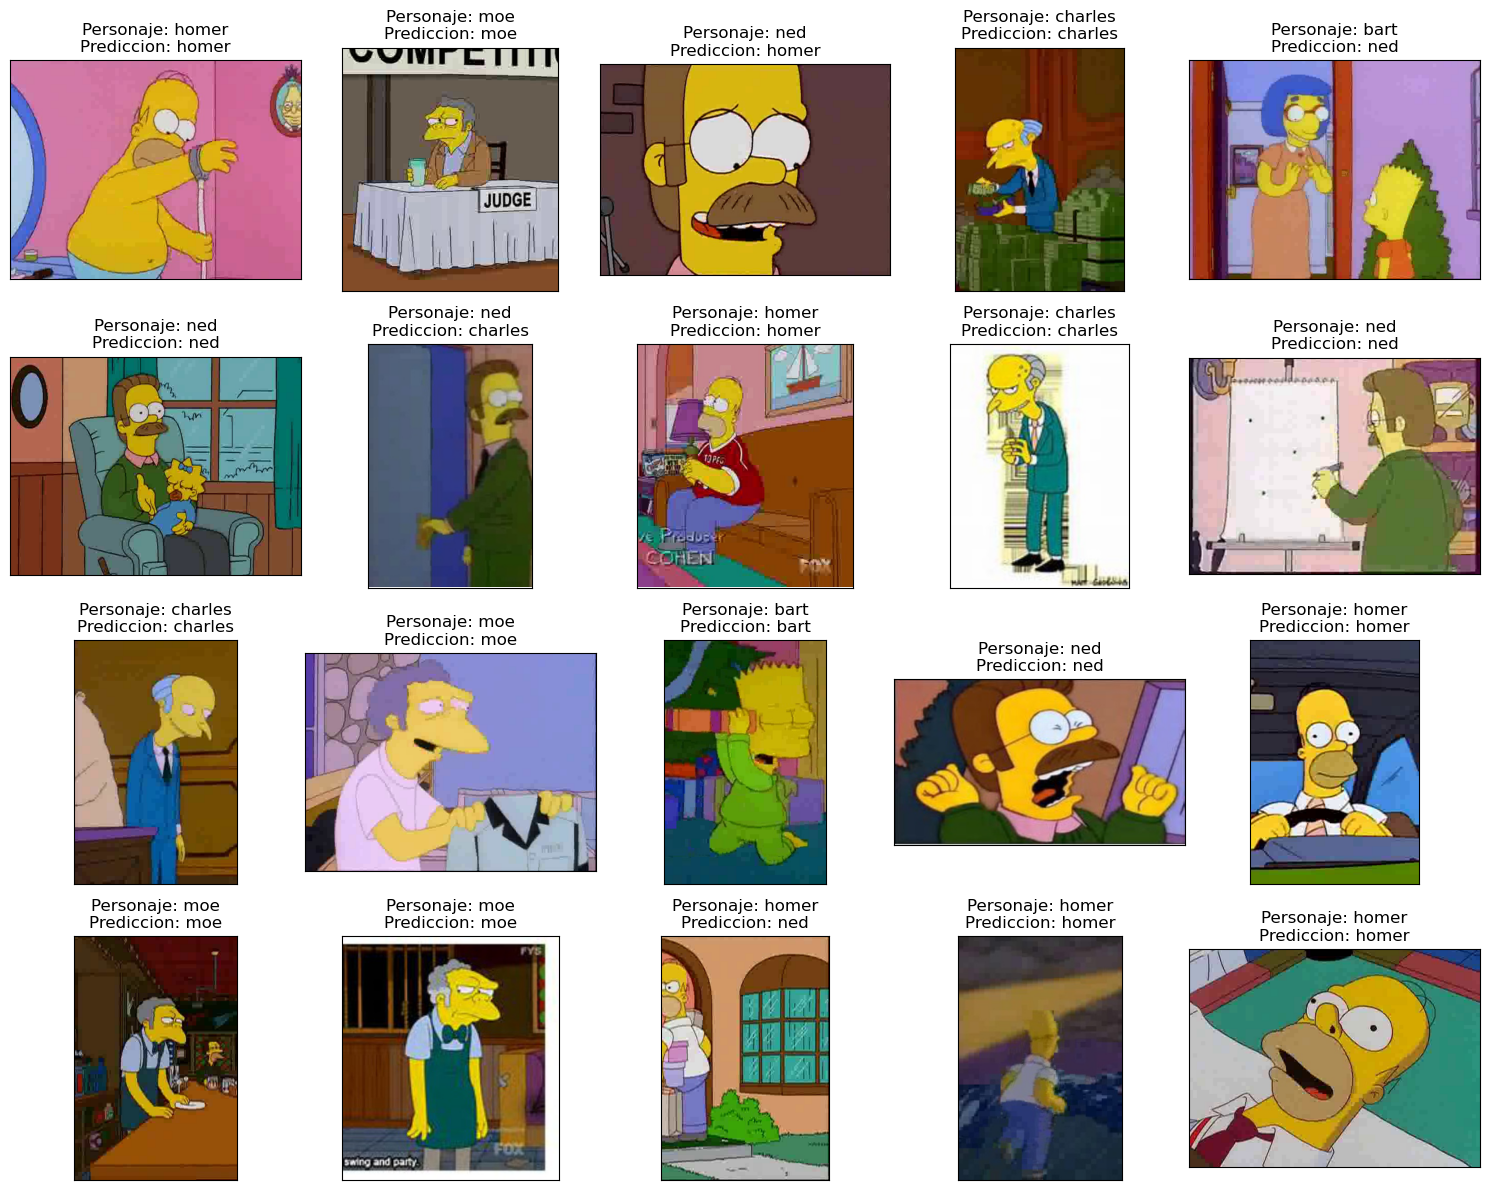

In [49]:
#5.1
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Personaje: {test_df.Label.iloc[i].split('_')[0]}\nPrediccion: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()